## Forecasting with decomposition
***
Time series decomposition (discussed in Chapter 3) can be a useful step in producing forecasts.

Assuming an additive decomposition, the decomposed time series can be written as

$y_{t} = \hat{S}_{t} + \hat{A}_{t}$

where $\hat{A}_{t} = \hat{T}_{t} + \hat{R}_{t}$ is the seasonally adjusted component. Or, if a multiplicative decomposition has been used, we can write

$y_{t} = \hat{S}_{t}\hat{A}_{t}$

where $\hat{A}_{t} = \hat{T}_{t}\hat{R}_{t}$

To forecast a decomposed time series, we forecast the seasonal component,$\hat{S}_{t}$, and the seasonally adjusted component $\hat{A}_{t}$, separately. It is usually assumed that the seasonal component is unchanging, or changing extremely slowly, so it is forecast by simply taking the last year of the estimated component. In other words, a seasonal naïve method is used for the seasonal component.

To forecast the seasonally adjusted component, any non-seasonal forecasting method may be used. For example, the drift method, or Holt’s method (discussed in Chapter 8), or a non-seasonal ARIMA model (discussed in Chapter 9), may be used.

## Example: Employment in the US retail sector

In [221]:
#Import the libraries that we are going to use for the analysis:
import pandas as pd
import numpy as np
from statsforecast import StatsForecast
from statsforecast.models import RandomWalkWithDrift
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [222]:
# the mstl() function performs decomposition of a time series into seasonal, trend and irregular components using Loess:
def mstl(x, period, blambda=None, s_window=7 + 4 * np.arange(1, 7)):
    origx = x
    n = len(x)
    msts = period
    # iterate = 1
    if x.ndim == 2:
        x = x[:, 0]
    if np.isnan(x).any():
        ...  # na.interp
    if blambda is not None:
        ...  # boxcox
    # tt = np.arange(n)
    if msts > 1:
        fit = sm.tsa.STL(x, period=msts, seasonal=s_window[0]).fit()
        seas = fit.seasonal
        deseas = x - seas
        trend = fit.trend
    else:
        try:
            from supersmoother import SuperSmoother
        except ImportError as e:
            print("supersmoother is required for mstl with period=1")
            raise e
        msts = None
        deseas = x
        t = 1 + np.arange(n)
        trend = SuperSmoother().fit(t, x).predict(t)
    deseas[np.isnan(origx)] = np.nan
    remainder = deseas - trend
    output = {"data": origx, "trend": trend}
    if msts is not None:
        output["seasonal"] = seas
    output["remainder"] = remainder
    return pd.DataFrame(output)

In [223]:
# Create a dataframe from a csv file:
df_employment  = pd.read_csv("Assets/us_retail_employment.csv")

# Rename columns:
df_employment.columns = ["ds","us_retail_employment"]

# Convert string Date time into Python Date time:
df_employment['ds'] = pd.to_datetime(df_employment['ds'])

# Create a new column in the dataframe, unique_id:
df_employment["unique_id"] = "us_retail_employment"

# Decompose a time series:
mstl_df = mstl(df_employment['us_retail_employment'].values, 12, blambda=None, s_window=7 + 4 * np.arange(1, 7))

mstl_df.head(5)

,data,trend,seasonal,remainder
0,13260.2,13283.764147,3.020208,-26.584355
1,13227.7,13265.602025,-11.399244,-26.502781
2,13230.1,13247.120540,-6.105647,-10.914893
3,13240.0,13228.318999,-0.018675,11.699676
4,13215.6,13209.210282,-6.756441,13.146159


In [226]:
# Create a dataframe with trend values:
trend_employ_df = pd.DataFrame()
trend_employ_df['ds']  = df_employment['ds']
trend_employ_df['seasonally_adjusted_comp'] = mstl_df['trend']
trend_employ_df["unique_id"] = "seasonally_adjusted_comp"

trend_employ_df.head(5)

,ds,seasonally_adjusted_comp,unique_id
0,1990-01-01,13283.764147,seasonally_adjusted_comp
1,1990-02-01,13265.602025,seasonally_adjusted_comp
2,1990-03-01,13247.120540,seasonally_adjusted_comp
3,1990-04-01,13228.318999,seasonally_adjusted_comp
4,1990-05-01,13209.210282,seasonally_adjusted_comp


In [242]:
# Define the model, fit and predict:
from statsforecast.models import AutoARIMA

models = [AutoARIMA(season_length=12, approximation=True)]

fcst = StatsForecast(df=trend_employ_df, 
                     models=models,
                     freq="M",
                     n_jobs=-1)

levels = [80, 95]

forecasts = fcst.forecast(h=20, level=levels)

c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arim

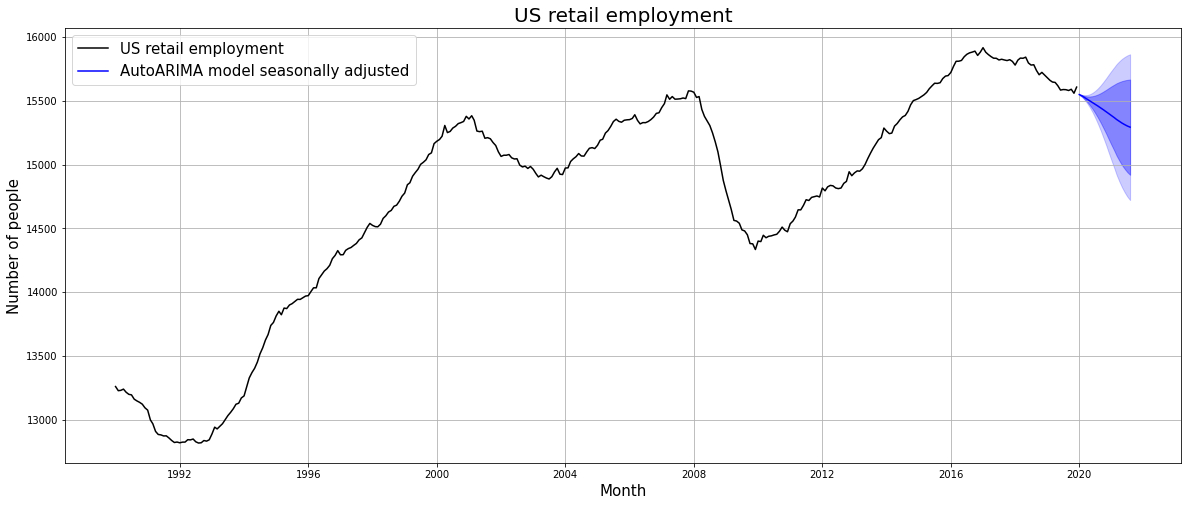

In [243]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
trend_fore_df = pd.concat([df_employment, forecasts]).set_index('ds')
plt.plot(trend_fore_df['us_retail_employment'], 'k-', trend_fore_df['AutoARIMA'], 'b-')

# Specify graph features:
ax.fill_between(trend_fore_df.index, 
                trend_fore_df['AutoARIMA-lo-80'], 
                trend_fore_df['AutoARIMA-hi-80'],
                alpha=.35,
                color='blue',
                label='auto_arima_level_80')
ax.fill_between(trend_fore_df.index, 
                trend_fore_df['AutoARIMA-lo-95'], 
                trend_fore_df['AutoARIMA-hi-95'],
                alpha=.2,
                color='blue',
                label='auto_arima_level_95')
ax.set_title('US retail employment', fontsize=20)
ax.set_ylabel('Number of people', fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax.legend(prop={'size': 15})
ax.legend(['US retail employment', 'AutoARIMA model seasonally adjusted'], prop={'size': 15})
ax.grid()


Figure 18 shows naïve forecasts of the seasonally adjusted US retail employment data. These are then “reseasonalised” by adding in the seasonal naïve forecasts of the seasonal component.

This is made easy with the `mstl()` function, which allows you to compute forecasts via any additive decomposition, using other model functions to forecast each of the decomposition’s components. Seasonal components of the model will be forecast automatically using `SNaive()` if a different model isn’t specified. The function will also do the reseasonalising for you, ensuring that the resulting forecasts of the original data are obtained. These are shown in Figure 19.



In [244]:
# Create a dataframe with seasonal values:
seasonal_employ_df = pd.DataFrame()
seasonal_employ_df['ds']  = df_employment['ds']
seasonal_employ_df['seasonal_comp'] = mstl_df['seasonal']
seasonal_employ_df['unique_id'] = 'seasonal_comp'

seasonal_employ_df.head(5)

,ds,seasonal_comp,unique_id
0,1990-01-01,3.020208,seasonal_comp
1,1990-02-01,-11.399244,seasonal_comp
2,1990-03-01,-6.105647,seasonal_comp
3,1990-04-01,-0.018675,seasonal_comp
4,1990-05-01,-6.756441,seasonal_comp


In [245]:
# SeasonalNaive's usage example:
from statsforecast.models import SeasonalNaive

models = [SeasonalNaive(season_length=12)]

fcst = StatsForecast(df=seasonal_employ_df, 
                     models=models,
                     freq="M",
                     n_jobs=-1)

forecasts = fcst.forecast(h=20, level=levels)

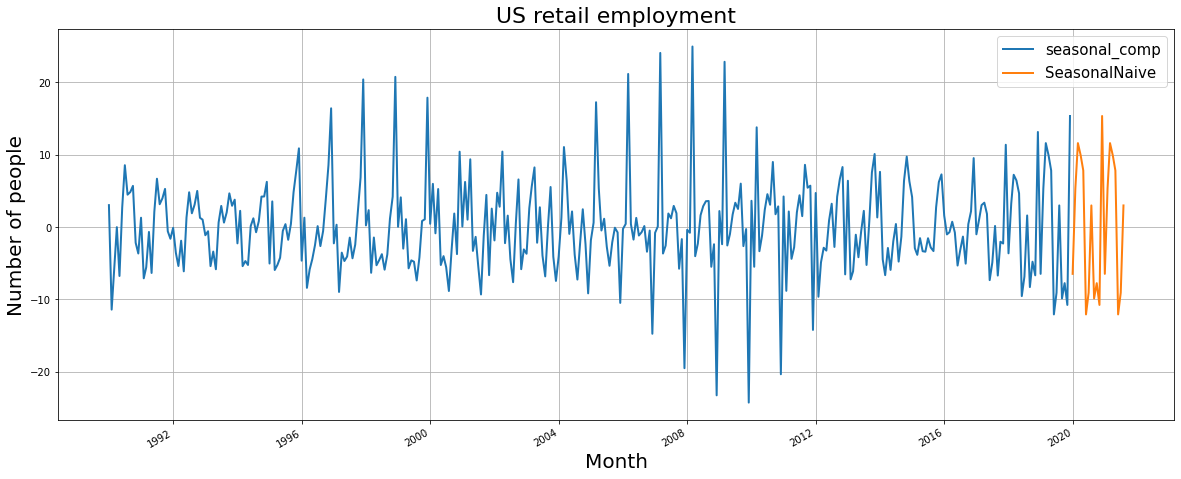

In [246]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

# Concatenate the dataframe of predicted values with the dataframe of observed values:
seasonal_fore_df = pd.concat([seasonal_employ_df, forecasts]).set_index('ds')
seasonal_fore_df[['seasonal_comp', 'SeasonalNaive']].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('US retail employment', fontsize=22)
ax.set_ylabel('Number of people', fontsize=20)
ax.set_xlabel('Month', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [235]:
# Reset the index of the trend_fore_df dataFrame:
trend_fore_df.reset_index(inplace=True)

In [236]:
# Create a dataframe with trend and seasonal forecasts values:
total_fore_df = pd.DataFrame({'ds':np.append(df_employment['ds'], trend_fore_df['ds']),
                    'us_retail_employment':df_employment['us_retail_employment'],
                    'AutoARIMA':(trend_fore_df['AutoARIMA'].values + seasonal_fore_df['SeasonalNaive']),
                    'AutoARIMA-lo-95':(trend_fore_df['AutoARIMA-lo-95'].values + seasonal_fore_df['SeasonalNaive']),
                    'AutoARIMA-lo-80':(trend_fore_df['AutoARIMA-lo-80'].values + seasonal_fore_df['SeasonalNaive']),
                    'AutoARIMA-hi-95':(trend_fore_df['AutoARIMA-hi-95'].values + seasonal_fore_df['SeasonalNaive']),
                    'AutoARIMA-hi-80':(trend_fore_df['AutoARIMA-hi-95'].values + seasonal_fore_df['SeasonalNaive'])})

total_fore_df.set_index('ds', inplace=True)
total_fore_df

,us_retail_employment,AutoARIMA,AutoARIMA-lo-95,AutoARIMA-lo-80,AutoARIMA-hi-95,AutoARIMA-hi-80
ds,,,,,,
1990-01-01,13260.2,NaN,NaN,NaN,NaN,NaN
1990-02-01,13227.7,NaN,NaN,NaN,NaN,NaN
1990-03-01,13230.1,NaN,NaN,NaN,NaN,NaN
1990-04-01,13240.0,NaN,NaN,NaN,NaN,NaN
1990-05-01,13215.6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2021-03-31,NaN,15349.848633,14878.534180,15041.672852,15821.164062,15821.164062
2021-04-30,NaN,15334.200195,14830.613281,15004.922852,15837.788086,15837.788086
2021-05-31,NaN,15302.128906,14771.044922,14954.872070,15833.211914,15833.211914


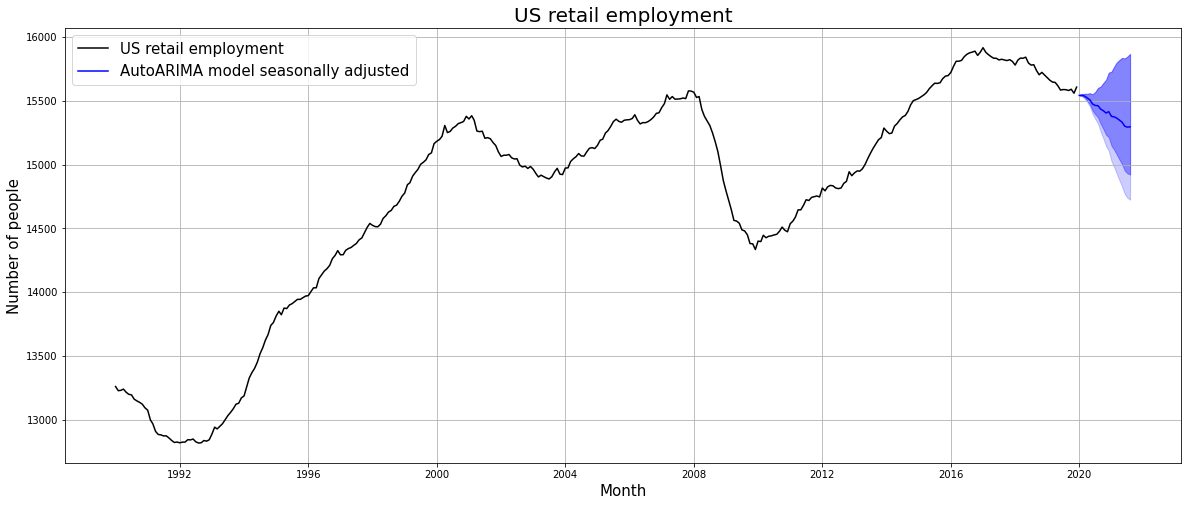

In [237]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))

plt.plot(total_fore_df['us_retail_employment'], 'k-', total_fore_df['AutoARIMA'], 'b-')

# Specify graph features:
ax.fill_between(total_fore_df.index, 
                total_fore_df['AutoARIMA-lo-80'], 
                total_fore_df['AutoARIMA-hi-80'],
                alpha=.35,
                color='blue',
                label='auto_arima_level_80')
ax.fill_between(total_fore_df.index, 
                total_fore_df['AutoARIMA-lo-95'], 
                total_fore_df['AutoARIMA-hi-95'],
                alpha=.2,
                color='blue',
                label='auto_arima_level_95')
ax.set_title('US retail employment', fontsize=20)
ax.set_ylabel('Number of people', fontsize=15)
ax.set_xlabel('Month', fontsize=15)
ax.legend(prop={'size': 15})
ax.legend(['US retail employment', 'AutoARIMA model seasonally adjusted'], prop={'size': 15})

ax.grid()

Figure 19: Forecasts of the total US retail employment data based on a naïve forecast of the seasonally adjusted data and a seasonal naïve forecast of the seasonal component, after an STL decomposition of the data.

The prediction intervals shown in this graph are constructed in the same way as the point forecasts. That is, the upper and lower limits of the prediction intervals on the seasonally adjusted data are “reseasonalised” by adding in the forecasts of the seasonal component.

The ACF of the residuals, shown in Figure 20, displays significant autocorrelations. These are due to the naïve method not capturing the changing trend in the seasonally adjusted series.

In [238]:
# Create a dataframe with observed, fitted and residuals values:

type_model_list = []
y_values = df_employment['us_retail_employment'].values
for n in range(len(df_employment)):
    type_model_list.append('AutoARIMA')
    n += 1
fitted_values = AutoARIMA(season_length=12, approximation=True).fit(df_employment['us_retail_employment'].values).predict_in_sample()
residuals = df_employment['us_retail_employment'].values - fitted_values["mean"]

augment_df = pd.DataFrame({'model':type_model_list,
                    'time_var':df_employment['ds'],
                    'obs_values':df_employment['us_retail_employment'].values,
                    'fitted_values':fitted_values["mean"],
                    'residuals':residuals})

augment_df.head()

c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arima.py:882: UserWarning: possible convergence problem: minimize gave code 2]
  warnings.warn(
c:\Users\Facu\AppData\Local\Programs\Python\Python310\lib\site-packages\statsforecast\arim

,model,time_var,obs_values,fitted_values,residuals
0,AutoARIMA,1990-01-01,13260.2,13246.939807,13.260193
1,AutoARIMA,1990-02-01,13227.7,13259.868734,-32.168734
2,AutoARIMA,1990-03-01,13230.1,13229.948951,0.151049
3,AutoARIMA,1990-04-01,13240.0,13226.873463,13.126537
4,AutoARIMA,1990-05-01,13215.6,13237.542737,-21.942737


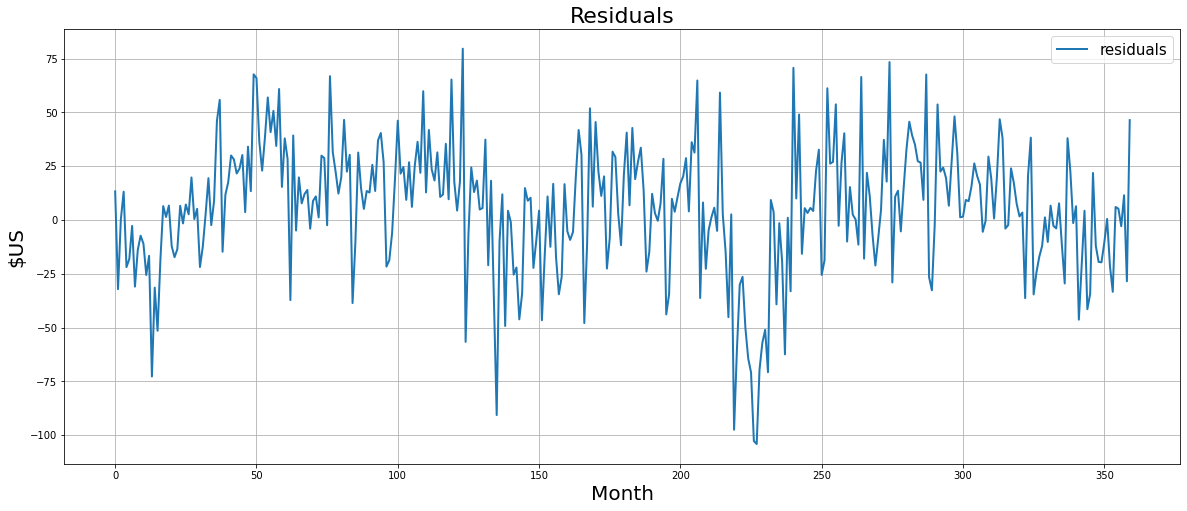

In [239]:
fig, ax = plt.subplots(1, 1, figsize = (20, 8))
augment_df['residuals'].plot(ax=ax, linewidth=2)

# Specify graph features:
ax.set_title('Residuals', fontsize=22)
ax.set_ylabel('$US', fontsize=20)
ax.set_xlabel('Month', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

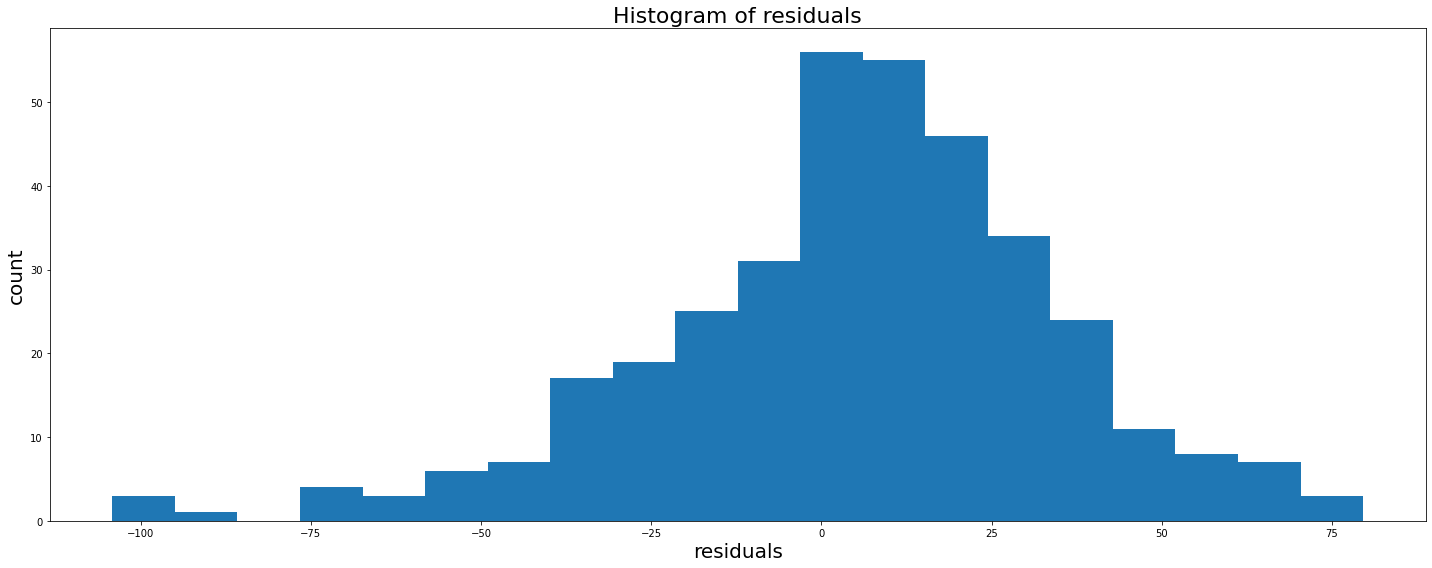

In [240]:
# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(20, 8),
                        tight_layout = True)
 
axs.hist(augment_df["residuals"], bins = 20)

# Specify graph features:
axs.set_title('Histogram of residuals', fontsize=22)
axs.set_ylabel('count', fontsize=20)
axs.set_xlabel('residuals', fontsize=20)
 
# Show plot
plt.show()

Text(0, 0.5, 'ACF')

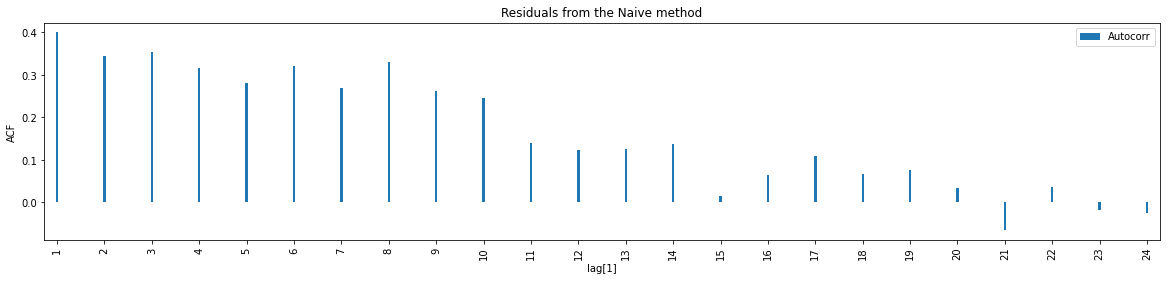

In [241]:
ticker_data = augment_df["residuals"]
ticker_data_acf = [ticker_data.autocorr(i) for i in range(1,25)]

test_df = pd.DataFrame([ticker_data_acf]).T
test_df.columns = ['Autocorr']
test_df.index += 1
test_df.plot(kind='bar', width = 0.05, figsize = (20, 4))

# Adding plot title.
plt.title("Residuals from the Naive method")
 
# Providing x-axis name.
plt.xlabel("lag[1]")

# Providing y-axis name.
plt.ylabel("ACF")

In subsequent chapters we study more suitable methods that can be used to forecast the seasonally adjusted component instead of the naïve method.